# Simulated Data Example
First I load the necssary packages and double check key packages versions.

In [3]:
# Import packages.
import demes
import demesdraw
from IPython.display import display, SVG
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
import tskit
# Print versions of our libraries.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('tskit', tskit.__version__)

demes 0.2.2
demesdraw 0.3.0
msprime 1.2.0
tskit 0.5.1


If the output of the above cell doesn't match `demes 0.2.1`, `demesdraw 0.3.0`, `msprime 1.1.1`, and `tskit 0.4.1` then this notebook will throw you one million error messages. I will now define two general functions, that I will need for the rest of this notebook.

## Model Sanity Check
Next I will use the same model as described in Racimo et al. 2017 and validate it using `msprime` and `demes`.

In [2]:
# Define IUA model of introgression.
def iua_human_model(f):
    # Intialize demographic model.
    iua_model = msprime.Demography()
    # We assume constant and equal effective population sizes for
    # all lineages.
    iua_model.add_population(name='AFR', initial_size=10_000)
    iua_model.add_population(name='EUR', initial_size=10_000)
    iua_model.add_population(name='NEA', initial_size=10_000)
    iua_model.add_population(name='AMH', initial_size=10_000)
    iua_model.add_population(name='HUM', initial_size=10_000)
    # Introgression from the Neanderthal to the Eurasian lineage
    # occuring 1,600 generations ago with a probability of f.
    iua_model.add_mass_migration(
        time=1_600, source='EUR', dest='NEA', proportion=f,
    )
    # The African and Eurasian lineages merge into the anatomically
    # modern human lineage 4,000 generations ago.
    iua_model.add_population_split(
        time=4_000, derived=['AFR', 'EUR'], ancestral='AMH',
    )
    # The anatomically modern human and Neanderthal lineages merge
    # into the ancestral human lineage 16,000 generations ago.
    iua_model.add_population_split(
        time=16_000, derived=['AMH', 'NEA'], ancestral='HUM',
    )
    return iua_model
# Sanity check to make sure the model is right.
test_model = iua_human_model(0.03)
test_model.debug()

NameError: name 'msprime' is not defined

Looks good but lets visualize this model as a sanity check.

<AxesSubplot:ylabel='time ago (generations)'>

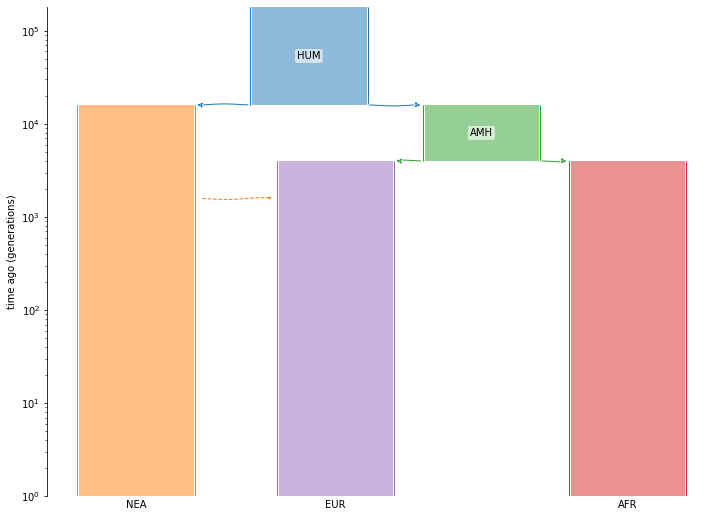

In [3]:
# Convert the demographic object to a demes graph.
test_graph = msprime.Demography.to_demes(test_model)
# Visualize the demes graph.
fig, ax = plt.subplots(figsize=(12,9))
demesdraw.tubes(test_graph, ax=ax, log_time=True)

## Example Simulation
Here I will walk through a simulation using the `iua_human_model()` function we defined earlier.

In [4]:
# Simulate a tree sequence.
ex_ts_f_03 = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(2, ploidy=1, population='AFR'), # Sample two haplotypes from AFR for our HMM.
        msprime.SampleSet(1, ploidy=1, population='EUR'),
        msprime.SampleSet(1, ploidy=1, population='NEA'),
    ],
    demography=iua_human_model(0.03), # Rate of introgression at 0.03.
    sequence_length=20_000_000, # Generate 20 Mb haplotypes per samples.
    recombination_rate=1e-8,
    record_migrations=True, # Need this to keep track of what segments are introgressed.
    discrete_genome=False,
    random_seed=42,
)
# Overlay mutations.
ex_mts_f_03 = msprime.sim_mutations(
    tree_sequence=ex_ts_f_03, rate=1.5e-8,
    model='jc69', random_seed=42,
    discrete_genome=False,
)
# View the mutated tree-sequence summary.
ex_mts_f_03

Ok so now we will look at the genotype matrix, where the first two indicies (i.e., 0 and 1) are the two `AFR` haplotypes, the third index (i.e., 2) is the `EUR` haplotype, and the fourth index (i.e., 3) is the `NEA` haplotype.

In [3]:
# View the genotype matrix.
ex_genotype_matrix = ex_mts_f_03.genotype_matrix()
print(ex_genotype_matrix)
print('There are {0} variants between 4 haplotypes of 20 Mb'.format(ex_genotype_matrix.shape[0]))

NameError: name 'ex_mts_f_03' is not defined

Next lets just run another sanity check to make sure there are that many positions.

In [6]:
# Grab the positions of the variable sites.
ex_variable_positions = ex_mts_f_03.tables.sites.position
print(ex_variable_positions)
print('There are {0} variants between 4 haplotypes of 20 Mb'.format(ex_variable_positions.shape[0]))

[1.14582156e+03 1.27624698e+03 1.68033211e+03 ... 1.99994501e+07
 1.99997610e+07 1.99999921e+07]
There are 33757 variants between 4 haplotypes of 20 Mb


So now we need to find the start and stop positions of the introgressed segments, which I will do with the `intro_ls_tracts()` function.

In [7]:
# Define a function to extract introgressed regions.
def intro_ls_tracts(
    ts,
    donor_pop_id,
    donor_samp_id,
    recipient_samp_id,
):
    """
    ###########################################################################
    INPUT
        ts: Simulated tree sequence.
        donor_pop_id: ID of the donor population.
        donor_samp_id: ID of the donor sample.
        recipient_samp_id: ID of the recipient sample.
    ---------------------------------------------------------------------------
    OUTPUT: NumPy array of start and end positions of tracts with a history of 
            introgression plus lineage sorting.
    ###########################################################################
    """
    # Intialize and empty list to store the output and tract length stopping
    # point.
    intro_ls_tracts = []
    tract_left = None
    # For all trees in the tree sequence.
    for tree in ts.trees():
        # Record the population of the MRCA node of our two target populations.
        mrca_pop = ts.node(tree.mrca(recipient_samp_id, donor_samp_id)).population
        # Record the left interval.
        left = tree.interval[0]
        # If the two target populations find their MRCA in the donor population,
        # i.e., if there is introgression + lineage sorting, and if we are not
        # already in an introgressed tract.
        if mrca_pop == donor_pop_id and tract_left is None:
            # Record the left position as the start of the introgressed tract.
            tract_left = left
        # Else if the two target populations do not find their MRCA in the
        # donor population, and if the last tree was within and introgressed
        # tract.
        elif mrca_pop != donor_pop_id and tract_left is not None:
            # Record the introgressed tract from its intial start point to the
            # left position of the current tree.
            intro_ls_tracts.append((tract_left, left))
            tract_left = None
    # If the last tree in the tree sequence contains an introgressed tract.
    if tract_left is not None:
        # Then make the right value of the last introgressed tract the sequence
        # length.
        intro_ls_tracts.append((tract_left, ts.sequence_length))
    return np.array(intro_ls_tracts)
# Identify introgressed tracts.
ex_intro_tracts_array = intro_ls_tracts(
    ts=ex_ts_f_03,
    donor_pop_id=2,
    donor_samp_id=3,
    recipient_samp_id=2,
)
print(ex_intro_tracts_array)
# Intilaize the start and stop lists.
ex_starts = ex_intro_tracts_array[:,0]
ex_stops = ex_intro_tracts_array[:,1]
ex_lengths = ex_intro_tracts_array[:,1] - ex_intro_tracts_array[:,0]
# Print a summary.
print('Start positions of introgressed regions: {0}'.format(ex_starts))
print('Stop positions of introgressed regions: {0}'.format(ex_stops))
print('Introgressed regions lengths: {0}'.format(ex_lengths))

[[  805054.61032182   822138.24202034]
 [  826407.7993745    827822.98781058]
 [  881057.19230797  1009036.89777329]
 [ 1013842.35828049  1023616.52767661]
 [ 1345187.84542486  1351871.10525993]
 [ 1354379.15265139  1359286.73812832]
 [ 1360243.53686843  1373180.81628828]
 [ 1378751.18079394  1381272.49190307]
 [ 1387091.34965617  1395285.54356949]
 [ 5681373.58408756  5686994.47048812]
 [ 7042687.72284607  7046252.01784735]
 [ 7049701.86373817  7050827.35636242]
 [ 7065112.39562733  7065883.14937669]
 [ 7082515.41149341  7163541.39393841]
 [12186831.14509647 12190025.4287044 ]
 [12790818.83164454 12794927.54465557]
 [12797717.82811598 12807013.20045325]
 [12812798.14717509 12823332.95395597]
 [13094311.32929789 13103567.16836905]
 [13655012.97851676 13655815.25379389]
 [13659082.66471021 13659363.30106126]
 [13668115.20428002 13677121.17901357]
 [13697623.99347467 13715561.4342309 ]
 [13719739.0634523  13748487.93184774]
 [15279184.19938415 15282347.70617339]
 [15290899.77291562 15291

Now lets run one last sanity check by checking the actual migration table.

In [8]:
# Print the number of start and stop positions for introgressed regions.
print('There are {0} start and {1} stop positions for introgressed regions.'.format(len(ex_starts), len(ex_stops)))
# Print out the migration table.
ex_mts_f_03.tables.migrations

There are 33 start and 33 stop positions for introgressed regions.


id,left,right,node,source,dest,time,metadata
0,13638495.81029948,13748487.93184774,2,1,2,1600.00000000,b''
1,15279184.19938415,15282347.70617339,2,1,2,1600.00000000,b''
2,8596828.18594796,8620819.63459956,2,1,2,1600.00000000,b''
3,1345187.84542486,1399085.12575242,2,1,2,1600.00000000,b''
4,5681373.58408756,5686994.47048812,2,1,2,1600.00000000,b''
5,12186831.14509647,12197455.46709356,2,1,2,1600.00000000,b''
6,15368125.33992144,15475020.41151727,2,1,2,1600.00000000,b''
7,758792.68439868,1026249.02152703,2,1,2,1600.00000000,b''
8,7042687.72284607,7163541.39393841,2,1,2,1600.00000000,b''
9,12790818.83164454,12829667.44734010,2,1,2,1600.00000000,b''


Since all of our sanity checks look good lets generate this data!

## Generating Simulated Data Sanity Checks
First I will just come up with a toy example, do a sanity check, and then actually explain everything.

In [9]:
# For 1 replicate.
for rep in list(range(1, 2)):
    # Simulate a tree sequence.
    ts_f_03 = msprime.sim_ancestry(
        samples=[
            msprime.SampleSet(2, ploidy=1, population='AFR'), # Sample two haplotypes from AFR for our HMM.
            msprime.SampleSet(1, ploidy=1, population='EUR'),
            msprime.SampleSet(1, ploidy=1, population='NEA'),
        ],
        demography=iua_human_model(0.03), # Rate of introgression at 0.03.
        sequence_length=20_000_000, # Generate 20 Mb haplotypes per samples.
        recombination_rate=1e-8,
        record_migrations=True, # Need this to keep track of what segments are introgressed.
        discrete_genome=False,
        random_seed=rep,
    )
    # Overlay mutations.
    mts_f_03 = msprime.sim_mutations(
        tree_sequence=ts_f_03, rate=1.5e-8,
        model='jc69', random_seed=rep,
        discrete_genome=False,
    )
    # Extract the genotype matrix.
    genotype_matrix = mts_f_03.genotype_matrix()
    # Save the genotype matrix.
    np.savetxt(
        './rep_id_{0}_geno_mat.csv.gz'.format(rep),
        genotype_matrix,
        fmt='%d',
        delimiter=',',
        )
    # Extract the variable positions.
    variable_positions = mts_f_03.tables.sites.position
    # Save the variable positions.
    np.savetxt(
        './rep_id_{0}_var_pos.csv.gz'.format(rep),
        [variable_positions],
        fmt='%1.15f',
        delimiter=',',
        newline='\n',
    )
    # Identify introgressed tracts.
    ex_intro_tracts_array = intro_ls_tracts(
        ts=mts_f_03,
        donor_pop_id=2,
        donor_samp_id=3,
        recipient_samp_id=2,
    )
    # Save the introgressed segments.
    np.savetxt(
        './rep_id_{0}_intro_pos.csv.gz'.format(rep),
        ex_intro_tracts_array,
        fmt='%1.15f',
        delimiter=',',
        newline='\n',
    )
    # Save the tree-sequence just for good measures.
    mts_f_03.dump('./rep_id_{0}_mut_tree_seq.ts'.format(rep))
    # Progress Checker
    print('Finished simulating rep {0}!'.format(rep))

Finished simulating rep 1!


Cool cool cool, now lets just run one last sanity check.

In [10]:
# Load the mutated tree sequence.
rep_id_1_mts = tskit.load('./rep_id_1_mut_tree_seq.ts')
# Load the variable positions.
rep_id_1_var_pos = np.loadtxt('./rep_id_1_var_pos.csv.gz', delimiter=',')
# Load the genotype matrix.
rep_id_1_geno_mat = np.loadtxt('./rep_id_1_geno_mat.csv.gz', dtype=int, delimiter=',')
# Load the introgressed region dataframe.
rep_id_1_intro_pos_mat = np.loadtxt('./rep_id_1_intro_pos.csv.gz', delimiter=',')
# Inspect the tree-sequence summary.
rep_id_1_mts

In [11]:
# Check to see if the variable positions and polarize genotype matricies are identical.
var_pos_check = np.array_equal(rep_id_1_var_pos, rep_id_1_mts.tables.sites.position)
geno_mat_check = np.array_equal(rep_id_1_geno_mat, rep_id_1_mts.genotype_matrix())
# Print the sanity check.
print('It is {0} that the variable positions are the same and {1} that the genotype matrices are the same.'.format(var_pos_check, geno_mat_check))

It is True that the variable positions are the same and True that the genotype matrices are the same.


Lastly lets inspect that introgressed regions are correct.

In [12]:
# Exported table.
rep_id_1_intro_pos_mat

array([[ 4266802.40544982,  4270541.23239524],
       [ 4273921.45499045,  4306920.58357239],
       [ 6847730.76064027,  6851206.03338254],
       [ 6859081.37492246,  6864195.34485407],
       [ 6889736.03683847,  6896547.93517433],
       [11575603.67786565, 11584807.05629304],
       [12838859.15053039, 12890747.49401362],
       [12908069.39080108, 12912870.13005533],
       [17048073.24540014, 17054358.40521257],
       [17056801.7422387 , 17084180.02323798],
       [17092384.60895333, 17092803.77460343],
       [17094817.83293084, 17106701.69422095],
       [17637920.95040557, 17637980.55257846]])

In [13]:
# Extract the panda columns into numpy arrays and round.
rep_id_1_intro_starts = rep_id_1_intro_pos_mat[:,0]
print('Starts: {0}'.format(rep_id_1_intro_starts))
rep_id_1_intro_stops = rep_id_1_intro_pos_mat[:,1]
print('Stops: {0}'.format(rep_id_1_intro_stops))

Starts: [ 4266802.40544982  4273921.45499045  6847730.76064027  6859081.37492246
  6889736.03683847 11575603.67786565 12838859.15053039 12908069.39080108
 17048073.24540014 17056801.7422387  17092384.60895333 17094817.83293084
 17637920.95040557]
Stops: [ 4270541.23239524  4306920.58357239  6851206.03338254  6864195.34485407
  6896547.93517433 11584807.05629304 12890747.49401362 12912870.13005533
 17054358.40521257 17084180.02323798 17092803.77460343 17106701.69422095
 17637980.55257846]


In [14]:
# Full migration table.
rep_id_1_mts.tables.migrations

id,left,right,node,source,dest,time,metadata
0,17048073.24540014,17124204.22858681,2,1,2,1600.00000000,b''
1,4266802.40544982,4306920.58357239,2,1,2,1600.00000000,b''
2,11575603.67786565,11584807.05629304,2,1,2,1600.00000000,b''
3,17614714.19041903,17637980.55257846,2,1,2,1600.00000000,b''
4,6847730.76064027,6900671.85646617,2,1,2,1600.00000000,b''
5,12838859.15053039,12920677.72946132,2,1,2,1600.00000000,b''
6,11978436.49893655,11996417.00681258,111,0,3,4000.00000000,b''
7,11996417.00681258,11996537.14914546,0,0,3,4000.00000000,b''
8,12000147.17796480,12020764.11448921,0,0,3,4000.00000000,b''
9,12020764.11448921,12106768.94586225,5,0,3,4000.00000000,b''
